# SVM

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold

## Data preperation

In [2]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df=df[['age','default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed']]

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['contact','month','poutcome']
df_encoded = pd.get_dummies(df['default'], prefix='default', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['default']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

#Changing pandas dataframe to numpy array
X = df

#Normalizing the data
sc = StandardScaler()
X = sc.fit_transform(X)    

#Convert to a pandaframe
X = pd.DataFrame(X, columns = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed'])

X.insert(0, 'ID', range(0, len(X)))
features = pd.merge(df_encoded, X, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [3]:
# split data into traininng and test data
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2, random_state=23)


## Grid search hyperparameter tuning

In [ ]:
# define hyperparameter search space
C= [0.1,1, 10]
gamma = [1,0.1,0.01,0.001]
kernel = ['linear','rbf']

# create dictionary from search space
grid = dict(
    svc__C=C,
    svc__gamma=gamma,
    svc__kernel=kernel,
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10, shuffle = True , random_state= 23)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), svm.SVC(C = 1 ,kernel = 'rbf', gamma = 'scale'))             

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=2, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore, bestParams))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  12.5s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.9s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.9s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.6s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.3s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  10.1s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  13.1s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   7.6s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   9.4s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   7.5s
[CV] END ..........svc__C=0.1, svc__gamma=1, s

In [4]:
# best hyperparameters
C = 1
gamma = 0.001
kernel = 'rbf'

## Undersample training data for further analysis

In [5]:
# undersample training data using nearmiss 1
nm = NearMiss(version = 1)
x_res, y_res = nm.fit_resample(train_features, train_targets)
train_features.shape,x_res.shape

((32950, 19), (7506, 19))

## Check for Overfitting

#### Check for overfitting by varying c

C: 0.100, train: 0.798, test: 0.705
C: 1.000, train: 0.798, test: 0.704
C: 10.000, train: 0.815, test: 0.647


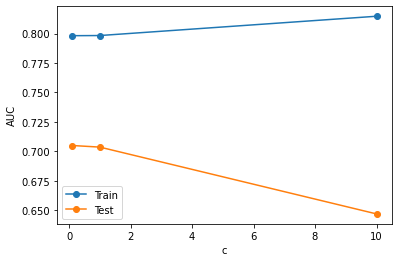

In [6]:
# define lists to collect scores
train_scores_c, test_scores_c = list(), list()

# define the C to evaluate
values = [0.1, 1, 10]
# evaluate the svm for C
for i in values:
    # configure the model
    model = svm.SVC(C=i ,kernel = kernel, gamma = gamma, probability=True).fit(
        x_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(x_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores_c.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores_c.append(test_acc)
    # summarize progress
    print('C: %.3f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores_c, '-o', label='Train')
pyplot.plot(values, test_scores_c, '-o', label='Test')
plt.ylabel('AUC')
plt.xlabel('c')
pyplot.legend()
pyplot.show()


#### Check for overfitting by varying gamma

Gamma: 1.000, train: 0.853, test: 0.609
Gamma: 0.100, train: 0.843, test: 0.636
Gamma: 0.010, train: 0.818, test: 0.641
Gamma: 0.001, train: 0.798, test: 0.704


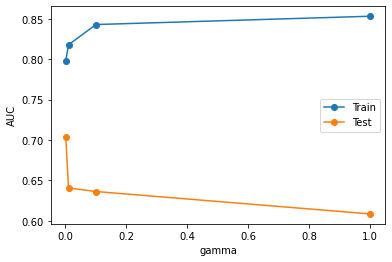

In [7]:
# define lists to collect scores
train_scores_g, test_scores_g = list(), list()

# define gamma's to evaluate
values = [1,0.1,0.01,0.001]
# evaluate SVM models
for i in values:
    # configure the model
    model = svm.SVC(C=C ,kernel = kernel, gamma = i, probability=True).fit(
        x_res, y_res)
    # evaluate on the train dataset
    schatting = model.predict(x_res)
    train_acc = roc_auc_score(y_res, schatting)
    train_scores_g.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = roc_auc_score(test_targets, test_schatting)
    test_scores_g.append(test_acc)
    # summarize progress
    print('Gamma: %.3f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores_g, '-o', label='Train')
pyplot.plot(values, test_scores_g, '-o', label='Test')
plt.ylabel('AUC')
plt.xlabel('gamma')
pyplot.legend()
pyplot.show()

## Run final model on test data to get AUC

Mon Apr 18 20:14:19 2022
mean cross validation score: 0.877
Confusion Matrix:
[[5230 2121]
 [ 270  617]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      7351
           1       0.23      0.70      0.34       887

    accuracy                           0.71      8238
   macro avg       0.59      0.70      0.58      8238
weighted avg       0.87      0.71      0.76      8238



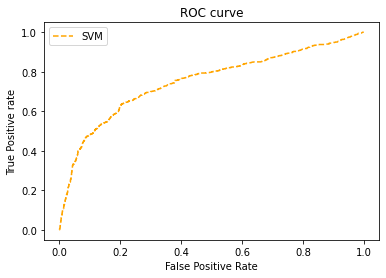

AUC Score: 0.75
Mon Apr 18 20:16:28 2022


In [8]:
# for model timing
print(time.ctime())

#SVM Classifier
classifier = svm.SVC(C= C ,kernel = kernel, gamma = gamma, probability=True)

k = 10
kf = StratifiedKFold(n_splits=k, shuffle = True, random_state = 23)
    
dt_scores = cross_val_score(classifier, x_res, y_res, scoring ='roc_auc' ,cv = kf)
print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))
    
classifier.fit(x_res, y_res)

predictions = classifier.predict(test_features)

print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))

print("Classification Report")
print(classification_report(test_targets, predictions))
    
#Beginning the plotting of ROC-curve
pred_prob = classifier.predict_proba(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
#Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='SVM')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
#AUC Score
auc_score = roc_auc_score(test_targets, pred_prob[:,1])
print("AUC Score: " + str(np.round(auc_score , 3)))

# for model timing
print(time.ctime())